# Recap: Bayesian Statistics
Bayesian statistics is an approach to statistical inference that applies Bayes' Theorem to update the probability estimate for a hypothesis as more evidence or data becomes available. Unlike frequentist statistics, which only considers the data at hand, Bayesian statistics incorporates prior knowledge or beliefs about the world and updates these beliefs as new data is observed.

In [51]:

import os
import nltk
import math
import string
import zipfile
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/kaleb/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kaleb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Download Dataset and unzip folder

In [52]:
def download_dataset(url, download_path):
    
    response = requests.get(url)

    if response.status_code == 200:
        with open(download_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded the file to {download_path}")
    else:
        print("Failed to download the file")

    with zipfile.ZipFile(download_path, 'r') as zip_ref:
        zip_ref.extractall("../data")
        print("Unzipped the dataset to '../data' folder")

    extracted_files = os.listdir("../data")
    print("Extracted files:", extracted_files)

In [53]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
download_path = "../data/smsspamcollection.zip"

download_dataset(url, download_path)

Downloaded the file to ../data/smsspamcollection.zip
Unzipped the dataset to '../data' folder
Extracted files: ['smsspamcollection.zip', 'readme', 'SMSSpamCollection']


## Load the Dataset

In [54]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
df = pd.read_csv('../data/SMSSpamCollection', sep='\t', header=None, names=['label', 'message'])

In [55]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## Data Preprocessing

In [57]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [58]:
def clean_text(text):
    text = ''.join([char for char in text if char not in string.punctuation])
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['message'] = df['message'].apply(clean_text)

## Split dataset to training and test

In [59]:
X = df['message']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Calculations
### 1. Priors

The prior probabilities represent the probability of each class (spam or ham) in the training data.

- **P(spam)**: Probability that a message is spam.

$$
P(\text{spam}) = \frac{\text{Number of spam messages}}{\text{Total number of messages}}
$$

- **P(ham)**: Probability that a message is ham.

$$
P(\text{ham}) = \frac{\text{Number of ham messages}}{\text{Total number of messages}}
$$

### 2. Likelihoods

The likelihood represents the probability of observing a particular word given a class (spam or ham).

- **P(w | spam)**: Probability of word \( w \) occurring in a spam message.

$$
P(w | \text{spam}) = \frac{\text{Number of times } w \text{ appears in spam messages} + 1}{\text{Total number of words in spam messages} + |V|}
$$

- **P(w | ham)**: Probability of word \( w \) occurring in a ham message.

$$
P(w | \text{ham}) = \frac{\text{Number of times } w \text{ appears in ham messages} + 1}{\text{Total number of words in ham messages} + |V|}
$$

### 3. Posteriors

The posterior is the probability of a class (spam or ham) given a message. We calculate the posterior for each class using Bayes' Theorem.

- **P(spam | message)**: The probability that the message is spam given the words in the message.

$$
P(\text{spam} | \text{message}) \propto P(\text{spam}) \times \prod_{i=1}^{n} P(w_i | \text{spam})
$$

- **P(ham | message)**: The probability that the message is ham given the words in the message.

$$
P(\text{ham} | \text{message}) \propto P(\text{ham}) \times \prod_{i=1}^{n} P(w_i | \text{ham})
$$

### 4. Decision Rule

Finally, we classify the message by comparing the posteriors for each class. The class with the higher posterior probability is chosen:

$$
\hat{y} = \begin{cases} 
\text{spam} & \text{if } P(\text{spam} | \text{message}) > P(\text{ham} | \text{message}) \\
\text{ham} & \text{otherwise}
\end{cases}
$$


In [62]:
class BayesianClassifier:
    def __init__(self):
        self.p_spam = 0
        self.p_ham = 0
        self.p_word_given_spam = {}
        self.p_word_given_ham = {}
        self.vocab = []

    def calculate_priors(self, y_train):
        """
        Calculate the prior probabilities P(spam) and P(ham).
        P(spam) = (Number of spam messages) / (Total number of messages)
        P(ham) = (Number of ham messages) / (Total number of messages)
        """
        spam_count = sum(y_train)
        ham_count = len(y_train) - spam_count
        total_count = len(y_train)
        self.p_spam = spam_count / total_count
        self.p_ham = ham_count / total_count

    def calculate_likelihoods(self, X_train, y_train, vocab):
        """
        Calculate the likelihoods P(word|spam) and P(word|ham) using Laplace smoothing.
        P(word|spam) = (Count of word in spam messages + 1) / (Total number of words in spam + Vocabulary size)
        P(word|ham) = (Count of word in ham messages + 1) / (Total number of words in ham + Vocabulary size)
        """
        spam_word_counts = defaultdict(int)
        ham_word_counts = defaultdict(int)
        spam_total_words = 0
        ham_total_words = 0

        # Loop through each message and its label
        for message, label in zip(X_train, y_train):
            words = message.toarray().flatten()  # Convert sparse to dense vector and flatten
            for idx, count in enumerate(words):
                if count > 0:  # Word is present
                    word = vocab[idx]  # Get the word corresponding to this index
                    if label == 1:  # Spam
                        spam_total_words += count
                        spam_word_counts[word] += count
                    else:  # Ham
                        ham_total_words += count
                        ham_word_counts[word] += count

        # Apply Laplace smoothing
        vocab_size = len(vocab)
        self.p_word_given_spam = {word: (spam_word_counts.get(word, 0) + 1) / (spam_total_words + vocab_size)
                                  for word in vocab}
        self.p_word_given_ham = {word: (ham_word_counts.get(word, 0) + 1) / (ham_total_words + vocab_size)
                                 for word in vocab}

    def train(self, X_train, y_train, vocab):
        """
        Train the classifier by calculating priors and likelihoods.
        Arguments:
        - X_train: List of training messages (already vectorized)
        - y_train: List of labels (1 for spam, 0 for ham)
        - vocab: Set of all unique words in the training set
        """
        self.vocab = vocab
        self.calculate_priors(y_train)
        self.calculate_likelihoods(X_train, y_train, vocab)

    def predict(self, message):
        """
        Predict whether a message is spam or ham based on the likelihoods and priors.
        Uses the Naive Bayes formula:
        P(spam|message) ∝ P(spam) * P(word1|spam) * P(word2|spam) * ...
        P(ham|message) ∝ P(ham) * P(word1|ham) * P(word2|ham) * ...
        The class with the higher probability is the predicted label.
        """
        p_spam_given_message = math.log(self.p_spam)
        p_ham_given_message = math.log(self.p_ham)

        # Convert the sparse vector back to a dense format for token counts
        words = message.toarray().flatten()  # Convert sparse to dense vector and flatten
        for idx, count in enumerate(words):
            if count > 0:  # Word is present
                word = self.vocab[idx]  # Get the word corresponding to this index
                p_spam_given_message += math.log(self.p_word_given_spam.get(word, 1 / (len(self.vocab) + 1)))
                p_ham_given_message += math.log(self.p_word_given_ham.get(word, 1 / (len(self.vocab) + 1)))

        return 1 if p_spam_given_message > p_ham_given_message else 0

    def evaluate(self, X_test, y_test):
        """
        Evaluate the model on the test set.
        Arguments:
        - X_test: List of test messages (already vectorized)
        - y_test: List of true labels (1 for spam, 0 for ham)
        """
        predicted = [self.predict(message) for message in X_test]
        accuracy = accuracy_score(y_test, predicted)
        report = classification_report(y_test, predicted)
        cm = confusion_matrix(y_test, predicted)

        return accuracy, report, cm


Accuracy: 0.9839
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.97      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



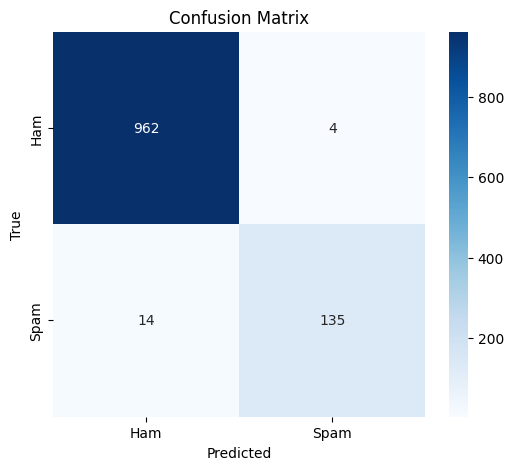

In [61]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize and train the classifier
classifier = BayesianClassifier()
classifier.train(X_train_vectorized, y_train, vectorizer.get_feature_names_out())

# Evaluate the model on the test data
accuracy, report, cm = classifier.evaluate(X_test_vectorized, y_test)


print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()